<a href="https://colab.research.google.com/github/RochX/comp486-assignments/blob/main/assignment5/assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5
Xavier Silva

## Part 1

### Setting Up The Data
Download the training and test data.
Load data into csv files.

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

# download and extract data
tarball_path = "sign_mnist.tgz"
if not Path(tarball_path).is_file():
  url = "https://github.com/RochX/comp486-assignments/raw/main/assignment5/sign_mnist.tgz"
  urllib.request.urlretrieve(url, tarball_path)
  with tarfile.open(tarball_path) as tarball:
    tarball.extractall()

sign_mnist_train = pd.read_csv("sign_mnist_train.csv", header=None).rename({0: "Letter"}, axis=1)
sign_mnist_test = pd.read_csv("sign_mnist_test.csv", header=None).rename({0: "Letter"}, axis=1)

Shuffle the data.

In [2]:
from sklearn.utils import shuffle
sign_mnist_train = shuffle(sign_mnist_train, random_state=42)
sign_mnist_test = shuffle(sign_mnist_test, random_state=42)

Relabel letter column and replace numbers with their corresponding letter (i.e. `0 --> A`, `1 --> B`, etc.)

In [3]:
def rename_letter_col(df):
  # letter_dict = {0: 'A', 1: 'B', ...}
  # letter_dict = {i:chr(i+65) for i in range(0,26)}
  df = df.rename({0: "Letter"}, axis=1)
  df.columns = df.columns.astype(str)
  # df["Letter"] = df["Letter"].replace(letter_dict)
  return df

sign_mnist_train = rename_letter_col(sign_mnist_train)
sign_mnist_test = rename_letter_col(sign_mnist_test)

Discover the data.

In [4]:
sign_mnist_train.head()

,Letter,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
16203,24,118,122,126,129,134,139,143,147,150,...,103,104,103,102,100,99,99,99,97,96
23292,8,173,173,174,174,175,176,176,177,177,...,146,139,127,100,177,232,220,223,223,221
7204,18,83,88,94,100,108,115,121,127,132,...,81,66,137,182,181,184,186,186,187,188
22591,2,167,169,168,167,167,169,169,169,169,...,223,223,222,221,220,220,218,217,218,193
3498,24,120,124,128,132,137,141,144,148,150,...,68,44,84,93,96,96,82,126,144,103


In [5]:
sign_mnist_train.describe()

,Letter,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


Scale the pixel data.

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

numerical_features = sign_mnist_train.select_dtypes(include=['int64', 'float64']).columns.drop("Letter").astype(str)

pixel_scaler = ColumnTransformer(transformers=[('num', MinMaxScaler(), numerical_features)],
    remainder='passthrough'
)
pixel_scaler.set_output(transform='pandas')

pixel_scaler.fit_transform(sign_mnist_train)

,num__1,num__2,num__3,num__4,num__5,num__6,num__7,num__8,num__9,num__10,...,num__776,num__777,num__778,num__779,num__780,num__781,num__782,num__783,num__784,remainder__Letter
16203,0.462745,0.478431,0.494118,0.505882,0.525490,0.545098,0.560784,0.576471,0.588235,0.596078,...,0.407843,0.403922,0.400000,0.392157,0.388235,0.388235,0.388235,0.380392,0.376471,24
23292,0.678431,0.678431,0.682353,0.682353,0.686275,0.690196,0.690196,0.694118,0.694118,0.698039,...,0.545098,0.498039,0.392157,0.694118,0.909804,0.862745,0.874510,0.874510,0.866667,8
7204,0.325490,0.345098,0.368627,0.392157,0.423529,0.450980,0.474510,0.498039,0.517647,0.521569,...,0.258824,0.537255,0.713725,0.709804,0.721569,0.729412,0.729412,0.733333,0.737255,18
22591,0.654902,0.662745,0.658824,0.654902,0.654902,0.662745,0.662745,0.662745,0.662745,0.662745,...,0.874510,0.870588,0.866667,0.862745,0.862745,0.854902,0.850980,0.854902,0.756863,2
3498,0.470588,0.486275,0.501961,0.517647,0.537255,0.552941,0.564706,0.580392,0.588235,0.592157,...,0.172549,0.329412,0.364706,0.376471,0.376471,0.321569,0.494118,0.564706,0.403922,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,0.466667,0.470588,0.474510,0.478431,0.494118,0.529412,0.564706,0.607843,0.631373,0.662745,...,0.564706,0.803922,0.870588,0.823529,0.796078,0.737255,0.611765,0.509804,0.513725,15
5390,0.701961,0.705882,0.709804,0.713725,0.721569,0.725490,0.717647,0.721569,0.725490,0.725490,...,0.149020,0.156863,0.243137,0.262745,0.301961,0.384314,0.380392,0.290196,0.203922,1
860,0.756863,0.760784,0.764706,0.772549,0.780392,0.784314,0.792157,0.796078,0.800000,0.800000,...,0.498039,0.498039,0.501961,0.498039,0.490196,0.486275,0.474510,0.470588,0.458824,14
15795,0.784314,0.788235,0.780392,0.776471,0.780392,0.780392,0.784314,0.784314,0.784314,0.772549,...,0.266667,0.180392,0.729412,0.666667,0.419608,0.458824,0.498039,0.278431,0.235294,7


Hold out the last 4,000 images from training set for validation.

In [7]:
num_for_validation = 4000
sign_mnist_train = sign_mnist_train[:-num_for_validation]
sign_mnist_validation = sign_mnist_train.iloc[-num_for_validation:]
sign_mnist_validation

,Letter,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
21246,2,182,182,181,182,183,183,182,183,184,...,229,228,227,227,227,225,224,225,222,220
18366,19,176,180,182,182,182,184,186,186,186,...,207,207,205,203,205,204,202,201,200,200
12658,0,158,160,161,163,165,168,169,170,170,...,79,168,217,211,212,212,212,211,211,212
8391,3,99,103,105,115,127,136,144,149,151,...,139,128,120,120,119,119,117,111,202,235
24069,20,79,84,100,118,130,134,142,151,156,...,77,10,12,45,37,17,11,32,29,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046,13,108,113,116,119,122,124,125,128,130,...,63,77,161,160,161,159,159,158,157,157
9227,10,183,185,186,186,186,186,187,186,185,...,85,165,244,229,229,228,200,129,75,63
5585,8,152,152,152,151,152,151,150,148,148,...,167,164,164,165,162,160,160,159,158,156
23303,20,144,146,149,151,153,154,155,156,157,...,179,178,178,177,176,175,173,172,170,168


In [8]:
sign_mnist_train

,Letter,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
16203,24,118,122,126,129,134,139,143,147,150,...,103,104,103,102,100,99,99,99,97,96
23292,8,173,173,174,174,175,176,176,177,177,...,146,139,127,100,177,232,220,223,223,221
7204,18,83,88,94,100,108,115,121,127,132,...,81,66,137,182,181,184,186,186,187,188
22591,2,167,169,168,167,167,169,169,169,169,...,223,223,222,221,220,220,218,217,218,193
3498,24,120,124,128,132,137,141,144,148,150,...,68,44,84,93,96,96,82,126,144,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6046,13,108,113,116,119,122,124,125,128,130,...,63,77,161,160,161,159,159,158,157,157
9227,10,183,185,186,186,186,186,187,186,185,...,85,165,244,229,229,228,200,129,75,63
5585,8,152,152,152,151,152,151,150,148,148,...,167,164,164,165,162,160,160,159,158,156
23303,20,144,146,149,151,153,154,155,156,157,...,179,178,178,177,176,175,173,172,170,168


### Training Models
Train a multiclass classifier using `SGDClassifier` and write down the score on the training set and test set.

In [9]:
def split_into_features_labels(df, *, label):
  features = df.drop(label, axis=1)
  labels = df[label]
  return features, labels

split_into_features_labels(sign_mnist_train, label="Letter")

(         1    2    3    4    5    6    7    8    9   10  ...  775  776  777  \
 16203  118  122  126  129  134  139  143  147  150  152  ...  103  104  103   
 23292  173  173  174  174  175  176  176  177  177  178  ...  146  139  127   
 7204    83   88   94  100  108  115  121  127  132  133  ...   81   66  137   
 22591  167  169  168  167  167  169  169  169  169  169  ...  223  223  222   
 3498   120  124  128  132  137  141  144  148  150  151  ...   68   44   84   
 ...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 6046   108  113  116  119  122  124  125  128  130  132  ...   63   77  161   
 9227   183  185  186  186  186  186  187  186  185  184  ...   85  165  244   
 5585   152  152  152  151  152  151  150  148  148  148  ...  167  164  164   
 23303  144  146  149  151  153  154  155  156  157  157  ...  179  178  178   
 5590    29   63   85   87   88   91   94   97  101  107  ...   13   15   14   
 
        778  779  780  781  782  783  

In [10]:
split_into_features_labels(sign_mnist_train, label="Letter")

(         1    2    3    4    5    6    7    8    9   10  ...  775  776  777  \
 16203  118  122  126  129  134  139  143  147  150  152  ...  103  104  103   
 23292  173  173  174  174  175  176  176  177  177  178  ...  146  139  127   
 7204    83   88   94  100  108  115  121  127  132  133  ...   81   66  137   
 22591  167  169  168  167  167  169  169  169  169  169  ...  223  223  222   
 3498   120  124  128  132  137  141  144  148  150  151  ...   68   44   84   
 ...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 6046   108  113  116  119  122  124  125  128  130  132  ...   63   77  161   
 9227   183  185  186  186  186  186  187  186  185  184  ...   85  165  244   
 5585   152  152  152  151  152  151  150  148  148  148  ...  167  164  164   
 23303  144  146  149  151  153  154  155  156  157  157  ...  179  178  178   
 5590    29   63   85   87   88   91   94   97  101  107  ...   13   15   14   
 
        778  779  780  781  782  783  

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
numerical_features = sign_mnist_train.select_dtypes(include=['int64', 'float64']).columns.drop("Letter").astype(str)
pipeline = Pipeline(
    [
        ('preprocessor', ColumnTransformer(transformers=[('num', MinMaxScaler(), numerical_features)], remainder='passthrough')),
        ('classifier', SGDClassifier(random_state=42))
    ]
)

pipeline.fit(*split_into_features_labels(sign_mnist_train, label="Letter"))
pipeline.score(*split_into_features_labels(sign_mnist_test, label="Letter"))

0.6422197434467373

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipeline, *split_into_features_labels(sign_mnist_test, label="Letter"), cv=5, scoring="accuracy")

array([0.99721254, 0.96585366, 0.97280335, 0.98256625, 1.        ])

Take some training instances and compare their labels and predicted labels.

In [14]:
example_features, example_labels = split_into_features_labels(sign_mnist_test.iloc[:5], label="Letter")
example_labels, pipeline.predict(example_features)

(2486     0
 3605    22
 4252     4
 2877    20
 4640     0
 Name: Letter, dtype: int64,
 array([ 0, 22, 18, 10,  0]))

### ANN
Create ANN using the sequential API to train a multiclass classifier model as follows:
1. Build the neural network with 2 dense hidden layers (300 neurons in the first hidden layer and 100 in the second).
2. Compile the neural network with `loss = "sparse_categorical_crossentropy"`,
`optimizer="sgd"`, and  `metrics="accuracy"`.
3. Train the neural network.
4. Plot the learning curves: the mean training loss and accuracy measured over each epoch, and the mean validation loss and accuracy measured at the end of each epoch.
5. Evaluate the ANN using the test set to estimate the generalization. **Write your observations (compare the score of ANN and SGDClassifier in question 6)**
6. Use the ANN to predict `X_new = Xtest[5:9]`. Did the ANN classify all images correctly? Prove your answer.

In [19]:
import tensorflow as tf
tf.random.set_seed(42)
ann_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[784]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(25, activation="softmax")
])

In [20]:
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 25)                2525      
                                                                 
Total params: 268125 (1.02 MB)
Trainable params: 268125 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
ann_model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="sgd",
                  metrics=["accuracy"])

In [22]:
train_features, train_labels = split_into_features_labels(sign_mnist_train, label="Letter")
history = ann_model.fit(train_features, train_labels,
                        epochs=30,
                        validation_data=split_into_features_labels(sign_mnist_validation, label="Letter"))

Epoch 1/30
733/733 [==============================] - 6s 7ms/step - loss: 2246479369171863552917504.0000 - accuracy: 0.0449 - val_loss: 3.2088 - val_accuracy: 0.0492
Epoch 2/30
733/733 [==============================] - 3s 4ms/step - loss: 3.2050 - accuracy: 0.0464 - val_loss: 3.2022 - val_accuracy: 0.0492
Epoch 3/30
733/733 [==============================] - 3s 4ms/step - loss: 3.1994 - accuracy: 0.0465 - val_loss: 3.1978 - val_accuracy: 0.0492
Epoch 4/30
733/733 [==============================] - 5s 6ms/step - loss: 3.1956 - accuracy: 0.0464 - val_loss: 3.1947 - val_accuracy: 0.0492
Epoch 5/30
733/733 [==============================] - 3s 4ms/step - loss: 3.1929 - accuracy: 0.0465 - val_loss: 3.1924 - val_accuracy: 0.0492
Epoch 6/30
733/733 [==============================] - 3s 4ms/step - loss: 3.1908 - accuracy: 0.0446 - val_loss: 3.1906 - val_accuracy: 0.0472
Epoch 7/30
733/733 [==============================] - 3s 4ms/step - loss: 3.1891 - accuracy: 0.0460 - val_loss: 3.1891 - val

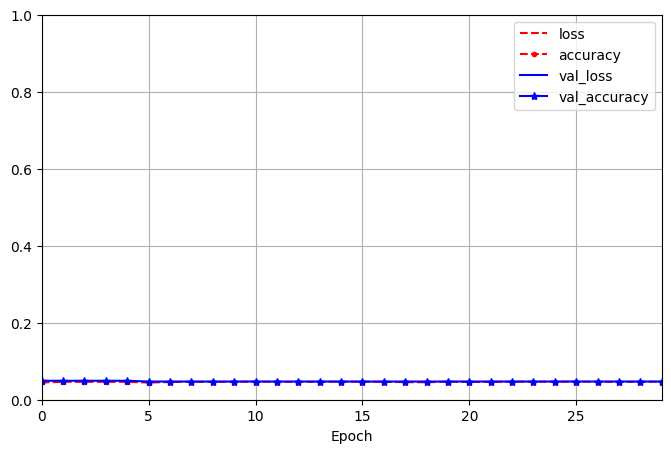

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5),
                                   xlim=[0, 29],
                                   ylim=[0, 1],
                                   grid=True,
                                   xlabel="Epoch",
                                   style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [24]:
ann_model.evaluate(*split_into_features_labels(sign_mnist_test, label="Letter"))

225/225 [==============================] - 1s 3ms/step - loss: 3.2060 - accuracy: 0.0201


[3.205958604812622, 0.020078081637620926]

In [25]:
X_new_features, X_new_labels = split_into_features_labels(sign_mnist_test, label="Letter")
X_new_features = X_new_features[5:9]
X_new_labels = X_new_labels[5:9]

ann_model.predict(X_new_features), X_new_labels

ValueError: not enough values to unpack (expected 2, got 0)

### Second ANN
Create a new ANN using the sequential API to train a multiclass classifier model with different hyperparameters values (add more hidden layers, add more neurons in the layers, increase epoch number, change the loss function and the optimizer)
- Evaluate the new ANN using the test set to estimate the generalization. **Write your observations (compare the score of the new ANN and the previous ANN in question 7)**

## Part 2
In this part you’ll use the “Data for Admission in the University” dataset from assignment 2 and assignment 4 to implement a regression ANN.

### Setting Up The Data
Download the data and load it as a csv file.

Split the data into train data (0.85) and test data (0.15).

Hold out the last 50 instances from the training set for validation.

### Creating ANN
Create ANN using the sequential API to train a regression model to predict the chance of
admission as follows:


Build the neural network with 3 dense hidden layers (100 neurons in each
hidden layer).

Compile the neural network with `loss="mse"`, `optimizer=Adam`, `metrics=['mse']`

Train the neural network.

Evaluate the ANN using the test set to estimate the generalization.
**Write your observations (compare the result of ANN with the linear regression medels in assignment 4 part 1)**

Use the ANN to predict `X_new = XTest[2]` and `X_new = XTest[50]`.
Did the ANN classify all images correctly? Prove your answer.